In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve


In [81]:
# read in the data
full_data = pd.read_csv('../Data/expanded_clean.csv', index_col=0)

# rename the 'class' column to 'poisonous' for clarity
# and convert to a binary variable
full_data.rename(columns={'class':'poisonous'}, inplace=True)
full_data['poisonous'] = full_data['poisonous'] == 'POISONOUS'

# Replace all '-' characters in the headers with '_'
full_data.columns = full_data.columns.str.replace('-', '_')

# Remove a ? from the headers
full_data.columns = full_data.columns.str.replace('?', '')

full_data.head()

<ipython-input-81-53970be0d0a3>:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  full_data.columns = full_data.columns.str.replace('?', '')


,poisonous,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,False,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,False,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
2,False,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
3,False,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
4,False,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS


In [86]:
#Function to compute confusion matrix and prediction accuracy
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
    pred_values = model.predict(data)
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

In [91]:
# Split the data into training and test sets
train, test = train_test_split(full_data, test_size=0.15, random_state=100)

# Model based on Odor
We noticed during the EDA that the odor of the mushroom is highly correlated with the toxicity of the mushroom, with an almost perfect correlation. We will use this as our first model.

In [92]:
# Create a model to predict poisonous using odor

train_1 = train.copy()

# If odor is equal to ALMOND, ANISE, or NONE, set it to 0, else 1
train_1['odor'] = train_1['odor'].apply(lambda x: 0 if x in ['ALMOND', 'ANISE', 'NONE'] else 1).astype(int)

train_1['poisonous'] = train_1['poisonous'].astype(int)

# Train a linear regression model
model_1 = smf.logit(formula='poisonous~odor', data=train_1).fit()
model_1.summary()

         Current function value: 0.065608
         Iterations: 35


/Users/jacksonbremen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              poisonous   No. Observations:                 7153
Model:                          Logit   Df Residuals:                     7151
Method:                           MLE   Df Model:                            1
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                  0.9050
Time:                        01:05:03   Log-Likelihood:                -469.30
converged:                      False   LL-Null:                       -4941.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.6334      0.101    -36.042      0.000      -3.831      -3.436
odor          29.9791   9253.047      0.003      0.997   -1.81e+04    1.82e+04
==============================================================================

Possibly complete quasi-separation: A fraction 0.45 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Classification accuracy = 98.5%
Precision = 100.0%
TPR or Recall = 96.8%
FNR = 3.2%
FPR = 0.0%
ROC-AUC = 98.4%


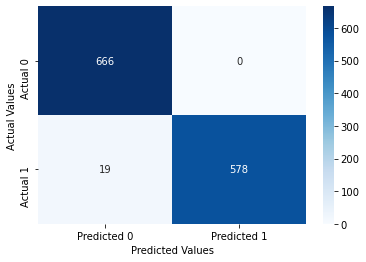

In [93]:
# Print the confusion matrix for test_1
test_1 = test.copy()
test_1['odor'] = test_1['odor'].apply(lambda x: 0 if x in ['ALMOND', 'ANISE', 'NONE'] else 1).astype(int)
test_1['poisonous'] = test_1['poisonous'].astype(int)

confusion_matrix_data(test_1[['odor']], test_1['poisonous'], model_1)

According to the confusion matrix run on the test data, the model is able to correctly predict 98.5% of the mushrooms, with 100% precision and 96.8% recall.

This is a very good model for our purposes.

# Model based on visual features
We will now try to create a model without the odor feature, and instead use the visual features of the mushroom. 

In [94]:
train

,poisonous,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
5321,True,FLAT,SCALY,YELLOW,NO,FOUL,FREE,CLOSE,BROAD,PINK,...,SILKY,BROWN,BUFF,PARTIAL,WHITE,ONE,LARGE,CHOCOLATE,SOLITARY,PATHS
6411,True,CONVEX,SCALY,RED,NO,FOUL,FREE,CLOSE,NARROW,BUFF,...,SILKY,PINK,WHITE,PARTIAL,WHITE,ONE,EVANESCENT,WHITE,SEVERAL,PATHS
1812,False,FLAT,SMOOTH,GRAY,NO,NONE,FREE,CROWDED,BROAD,CHOCOLATE,...,FIBROUS,WHITE,WHITE,PARTIAL,WHITE,ONE,EVANESCENT,BLACK,SCATTERED,GRASSES
7873,True,KNOBBED,SCALY,RED,NO,MUSTY,FREE,CLOSE,BROAD,YELLOW,...,SCALY,CINNAMON,CINNAMON,PARTIAL,WHITE,NONE,NONE,WHITE,CLUSTERED,WOODS
2197,False,CONVEX,FIBROUS,GRAY,BRUISES,NONE,FREE,CLOSE,BROAD,WHITE,...,SMOOTH,PINK,GRAY,PARTIAL,WHITE,ONE,PENDANT,BLACK,SEVERAL,WOODS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,False,BELL,SCALY,YELLOW,BRUISES,ANISE,FREE,CLOSE,BROAD,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,NUMEROUS,MEADOWS
79,False,FLAT,FIBROUS,WHITE,BRUISES,ANISE,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
8039,False,CONVEX,FIBROUS,WHITE,NO,NONE,FREE,CROWDED,BROAD,WHITE,...,SILKY,WHITE,WHITE,PARTIAL,WHITE,TWO,PENDANT,WHITE,NUMEROUS,GRASSES
6936,True,FLAT,SMOOTH,BROWN,NO,SPICY,FREE,CLOSE,NARROW,BUFF,...,SILKY,WHITE,PINK,PARTIAL,WHITE,ONE,EVANESCENT,WHITE,SEVERAL,PATHS


In [98]:
train_2 = train.copy()

# If odor is equal to ALMOND, ANISE, or NONE, set it to 0, else 1
train_2['odor'] = train_2['odor'].apply(lambda x: 0 if x in ['ALMOND', 'ANISE', 'NONE'] else 1).astype(int)
train_2['poisonous'] = train_2['poisonous'].astype(int)
# convert habitat to dummy variables
train_2 = pd.get_dummies(train_2, columns=['habitat'], drop_first=True)

formula = 'poisonous~odor'
formula += '+' + ':'.join(x for x in train_2.columns if x.startswith('habitat_'))

# Train a linear regression model
model_2 = smf.logit(formula=formula, data=train_2).fit()
model_2.summary()

         Current function value: inf
         Iterations: 35


/Users/jacksonbremen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/jacksonbremen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

In [99]:
formula

'poisonous~odor+habitat_LEAVES+habitat_MEADOWS+habitat_PATHS+habitat_URBAN+habitat_WASTE+habitat_WOODS'